In [1]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd

%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_58052/2104558896.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet') # choose the color map you want to use
/tmp/ipykernel_58052/2104558896.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_edge = plt.cm.get_cmap('plasma')


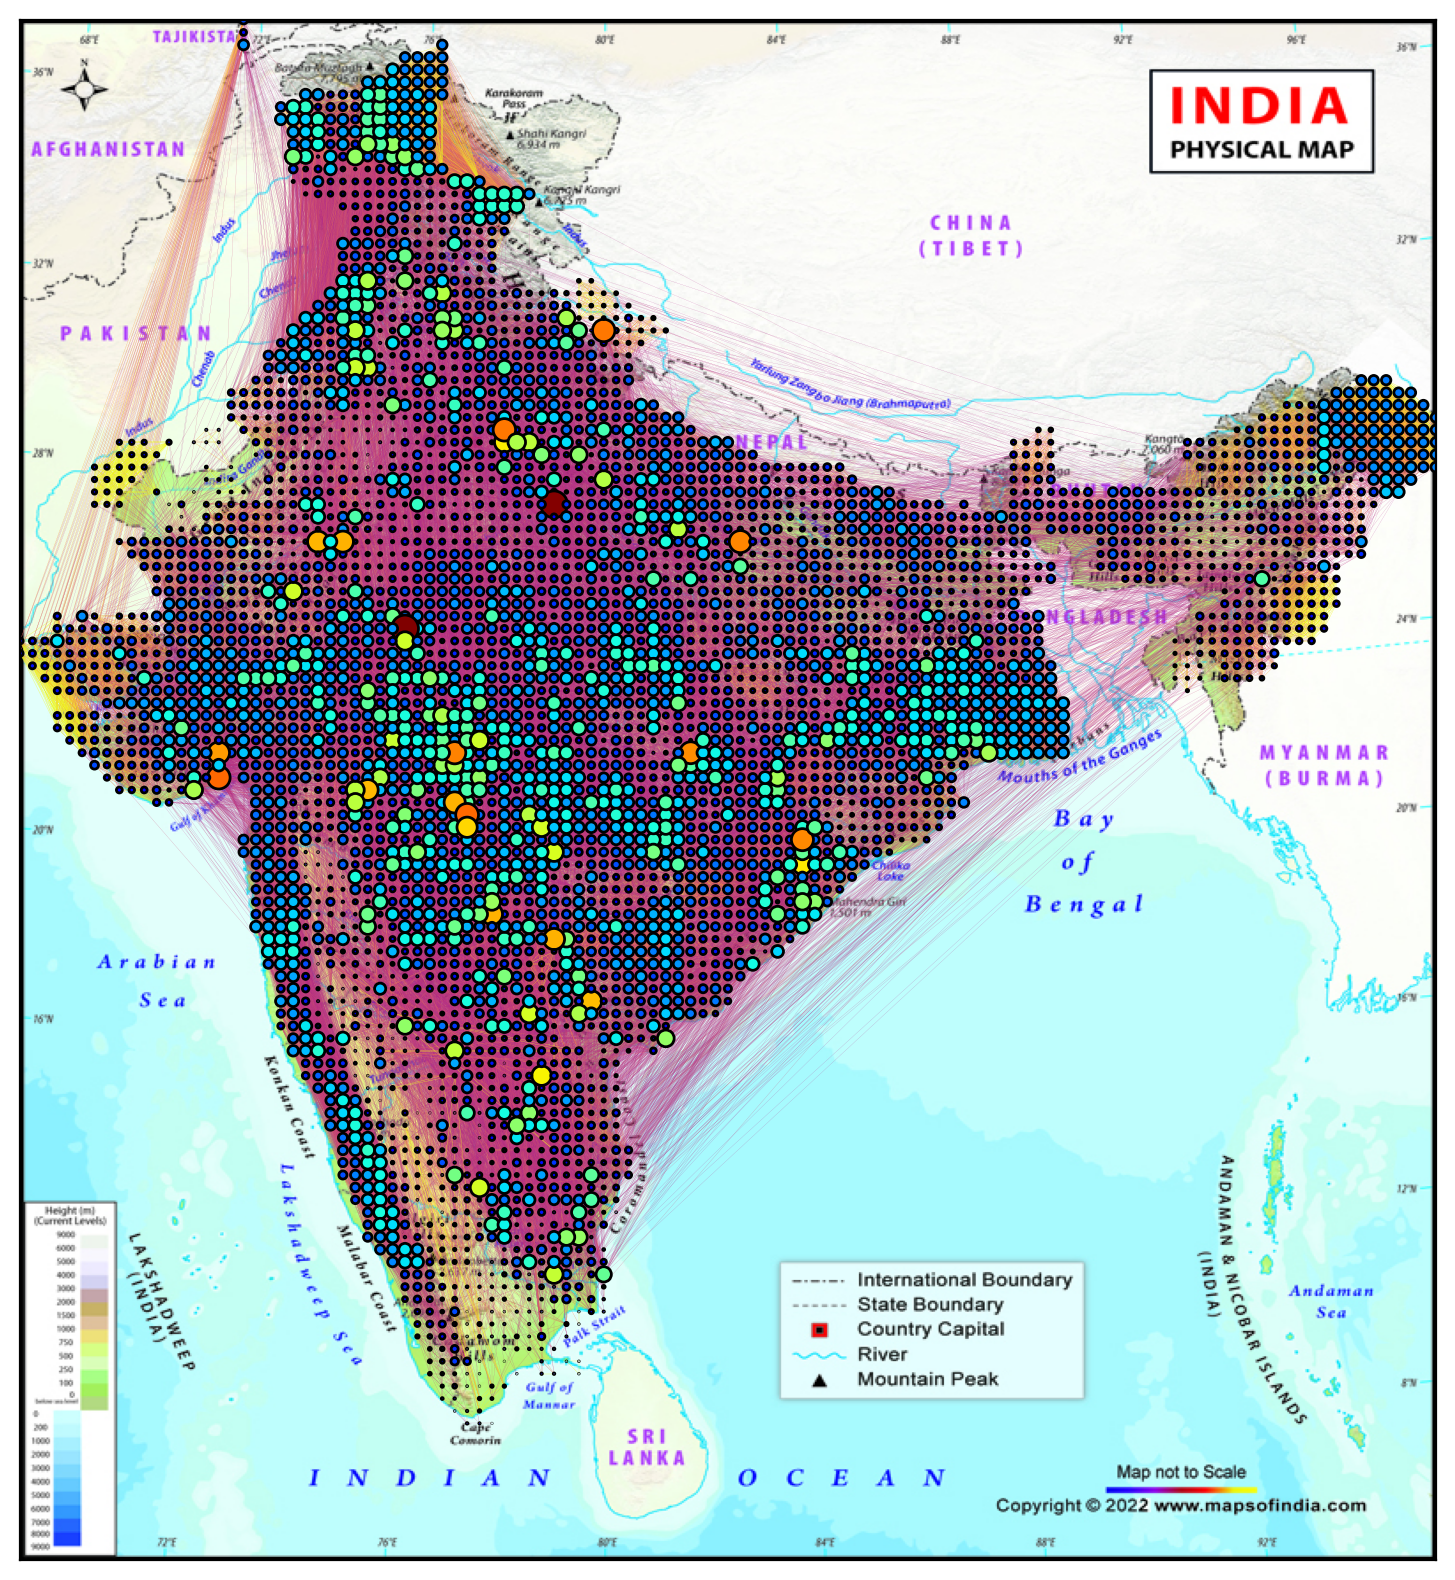

In [2]:
adj_matrix = np.load('/home/udit/Documents/Progyan/results_new_95/Decade_1901-1910.npy')
adj_matrix = adj_matrix + adj_matrix.transpose()
adj_matrix[adj_matrix < 0.4] = 0
np.fill_diagonal(adj_matrix, 0)

plt.figure(figsize=(10,10))
G = nx.from_numpy_matrix(adj_matrix)

# load latitude and longitude pairs from csv file
lat_lon_df = pd.read_csv('/home/udit/Documents/Progyan/lat_lon-1901.csv')

# create dictionary with node IDs as row indices and lat-lon tuples as values
lat_lon_dict = {}
for i in range(len(lat_lon_df)):
    lat_lon_dict[i] = (lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'])

# add latitudes and longitudes as node attributes
nx.set_node_attributes(G, lat_lon_dict, 'pos')

# get node positions
pos = nx.get_node_attributes(G, 'pos')

# create new dictionary with node positions only within India's geographical bounds
india_pos = {}
for node_id, coords in pos.items():
    if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
        india_pos[node_id] = coords

# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 10
# pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
# cmap the node colour based on degree 
degree_dict = dict(G.degree()) # calculate the degree of each node and convert to a dictionary
degree_values = np.array(list(degree_dict.values())) # convert the degree dictionary to an array

cmap = plt.cm.get_cmap('jet') # choose the color map you want to use
cmap_edge = plt.cm.get_cmap('plasma')

# normalize the degree values to a range between 0 and 1
normalized_degrees = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

# calculate the colors for each node based on its degree
node_colors = cmap(normalized_degrees)

# set edge width based on weight
edge_widths = [d['weight']*0.1 for (u, v, d) in G.edges(data=True)]
edge_colors = [d['weight'] for (u, v, d) in G.edges(data=True)]

edge_colors = cmap_edge(edge_colors)

# list of cmaps
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# they are, in order: virids,


nx.draw_networkx(G, pos = india_pos,
        nodelist=d, 
        width=edge_widths,
        edge_color=edge_colors,
        edgecolors = 'black',
        node_size=[(d[k])**1.5*0.02 for k in d],
        with_labels = False,
        # edge_color='grey',
        node_color=node_colors,)
# nx.draw_networkx(G, pos=india_pos, node_size=4, width=0.2, with_labels=False)
plt.savefig('graph1.png')

# superimpose an image with low alpha
img = plt.imread('/home/udit/Documents/Progyan/GNN/physical-map-india.jpg')
plt.imshow(img, extent=[68, 96.5, 5.5, 36.5], alpha=1)
plt.savefig('graph2.png')

In [3]:
# convert adjacency matrix to edge list
edge_list = set()
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i, j] > 0:
            append_edge = frozenset({i, j})
            edge_list.add(append_edge)
edge_list = [tuple(x) for x in list(edge_list)]

In [4]:
# add latlong as node features
node_features = []
for i in range(len(lat_lon_df)):
    node_features.append([lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat']])
node_features = torch.tensor(node_features, dtype=torch.float)


In [5]:
edge_list = torch.tensor(edge_list)
edge_list = edge_list.t()

In [6]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [7]:
from torch_geometric.data import Data

In [8]:
graph_data = Data(x=node_features, edge_index=edge_list)

In [9]:
graph_data

Data(x=[4527, 2], edge_index=[2, 122626])

In [10]:
# convert Data to networkx
from torch_geometric.utils import to_networkx
G = to_networkx(graph_data)


In [11]:
G = nx.from_numpy_matrix(adj_matrix)
G_ = to_networkx(graph_data)